In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
Data = pd.read_csv("Life Expectancy Data Cleaned.csv")
Data = Data.drop(["Unnamed: 0"], axis=1)
print(Data.columns)
print(np.unique(Data["Country"]))

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')
['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Antigua and Barbuda'
 'Argentina' 'Armenia' 'Australia' 'Austria' 'Azerbaijan' 'Bahamas'
 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin'
 'Bhutan' 'Bolivia (Plurinational State of)' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'Brunei Darussalam' 'Bulgaria' 'Burkina Faso'
 'Burundi' 'Cabo Verde' 'Cambodia' 'Cameroon' 'Canada'
 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia' 'Comoros'
 'Congo' 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus' 'Czechia' "Côte d'Ivoire"
 "Democratic People's Republic of Ko

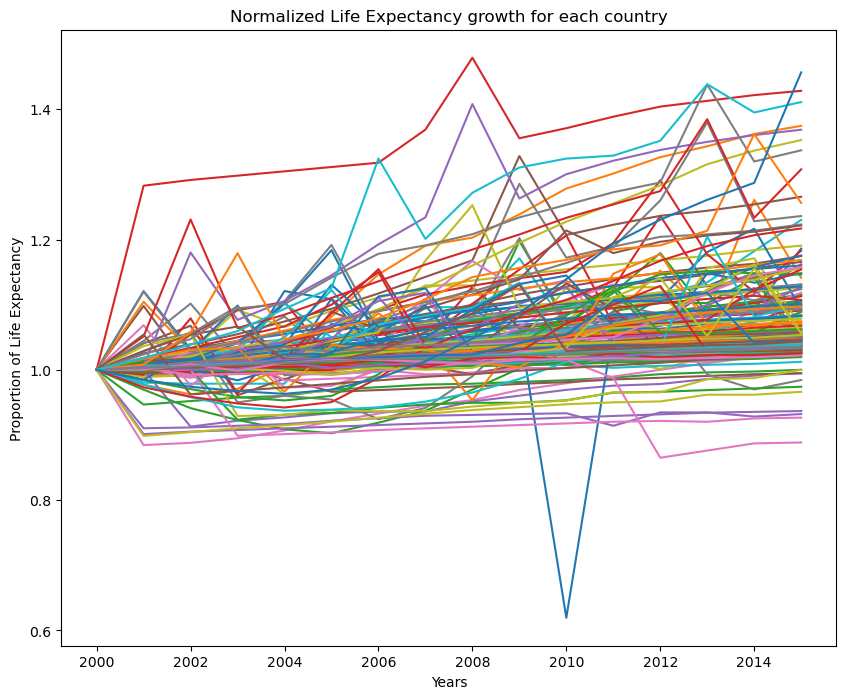

In [4]:
countries = np.unique(Data["Country"])

fig = plt.figure(figsize=(10,8))

for cont in countries:
    life_exp = Data[Data["Country"]==cont]["Life expectancy "].values
    years = Data[Data["Country"]==cont]["Year"].values
    year2000ind = np.where(years == min(years))  # for the purpose of separate cases where life exp is between 50-60, 60-70, 70-80, and so on.
    life_exp_2000 = life_exp[year2000ind][0]
    plt.plot(years,life_exp/life_exp_2000, label=cont)
plt.title("Normalized Life Expectancy growth for each country")
plt.ylabel("Proportion of Life Expectancy")
plt.xlabel("Years")
plt.show()

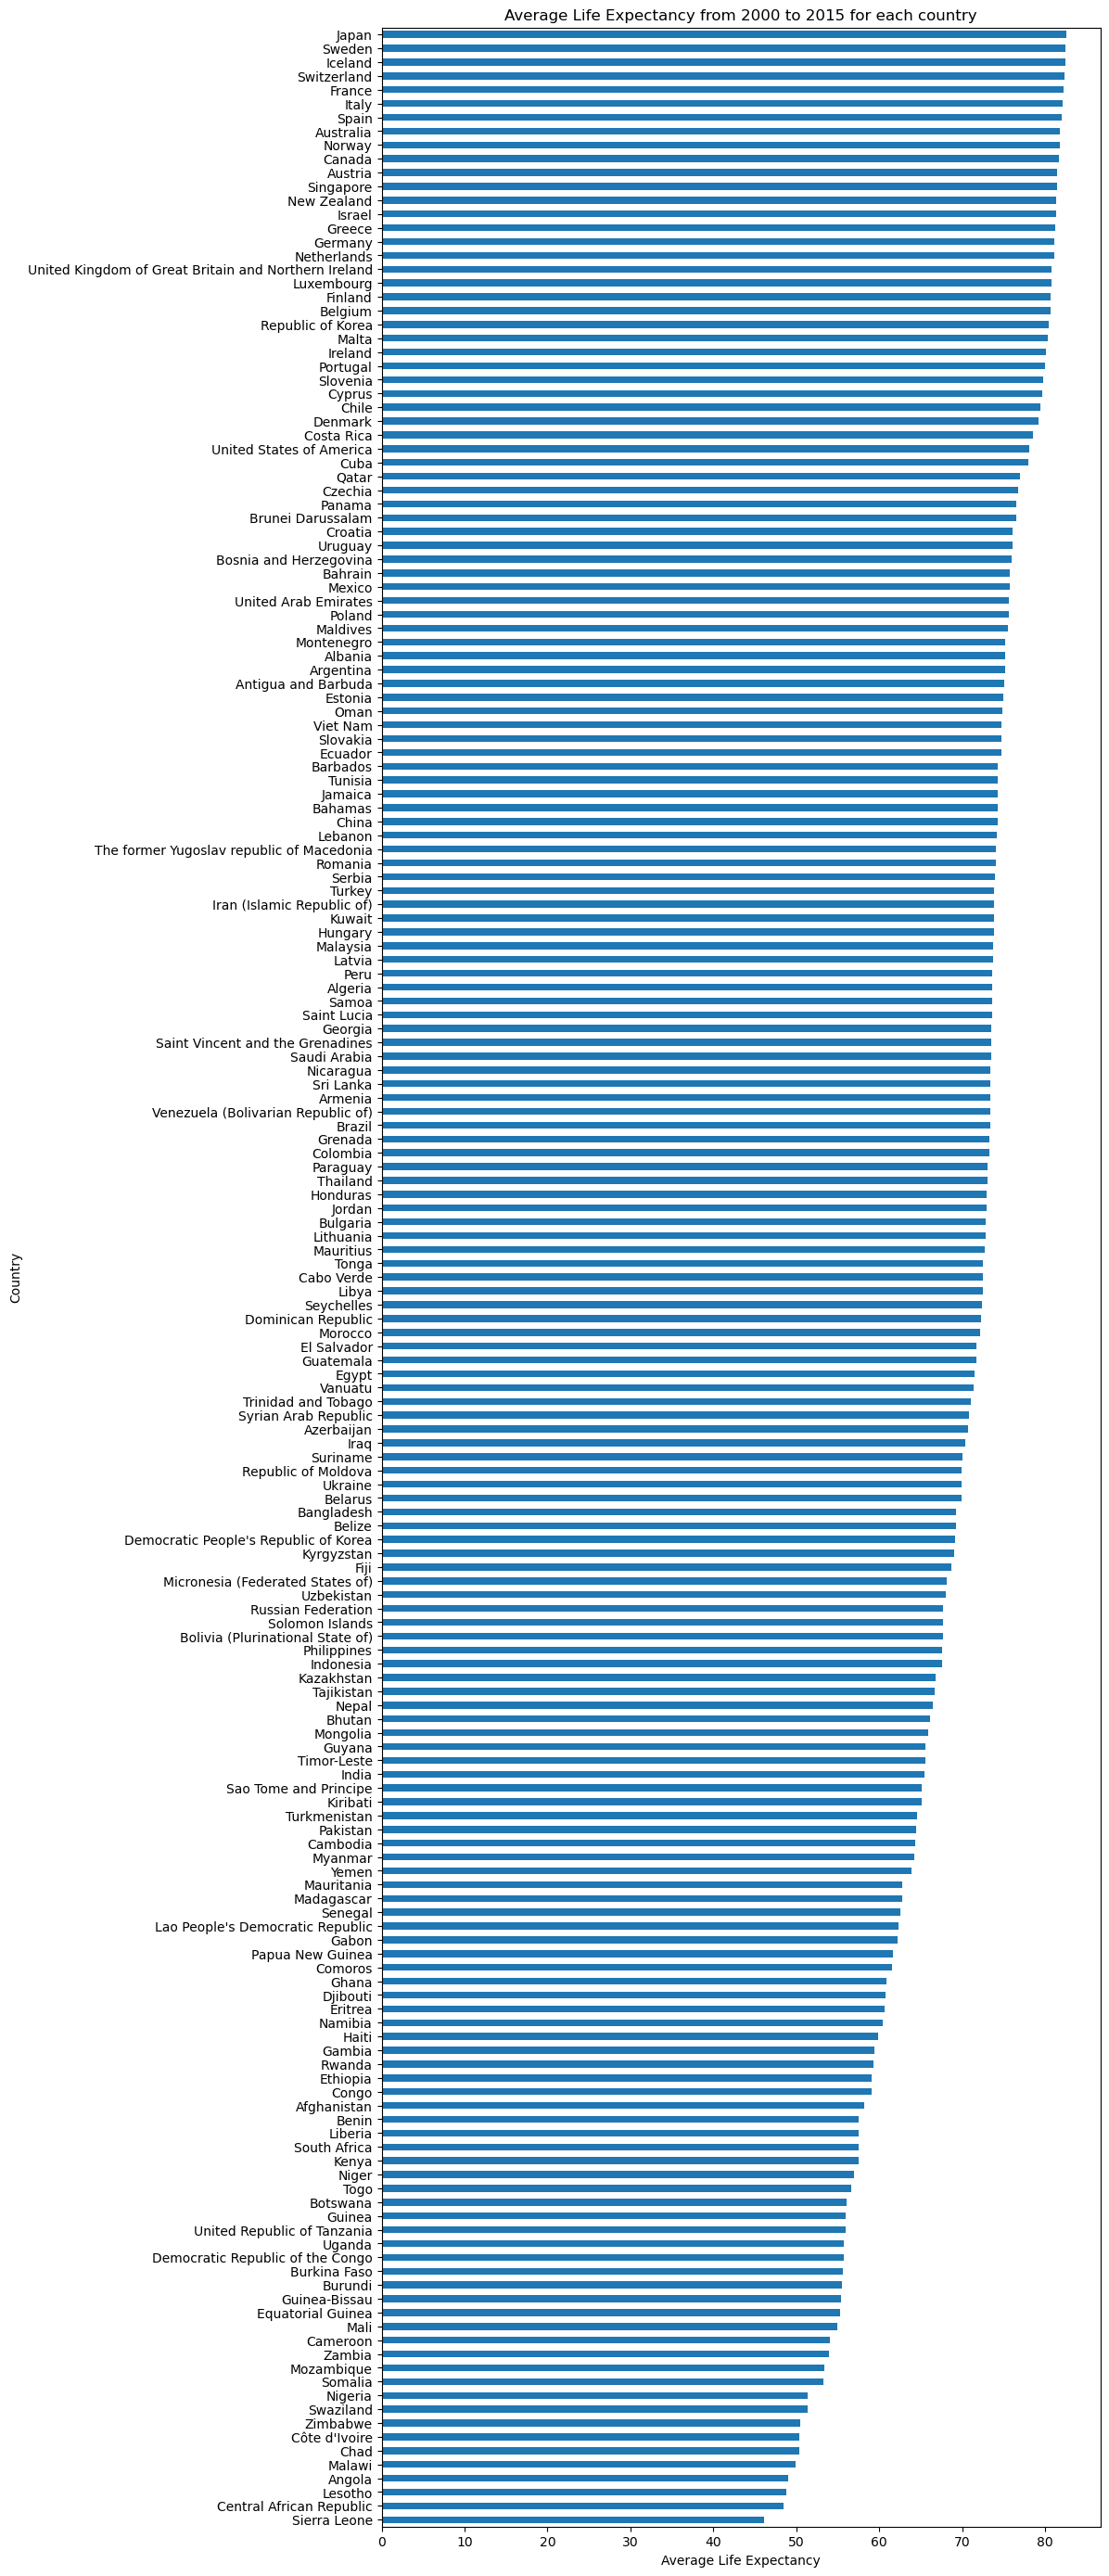

In [5]:
Data.groupby("Country")["Life expectancy "].mean().sort_values().plot(kind="barh", 
                                                                      title="Average Life Expectancy from 2000 to 2015 for each country", 
                                                                      xlabel="Average Life Expectancy",
                                                                      figsize=(10,35))
plt.show()

# ***Correlation Analysis***

**Title:** *Life Expectancy vs GDP*

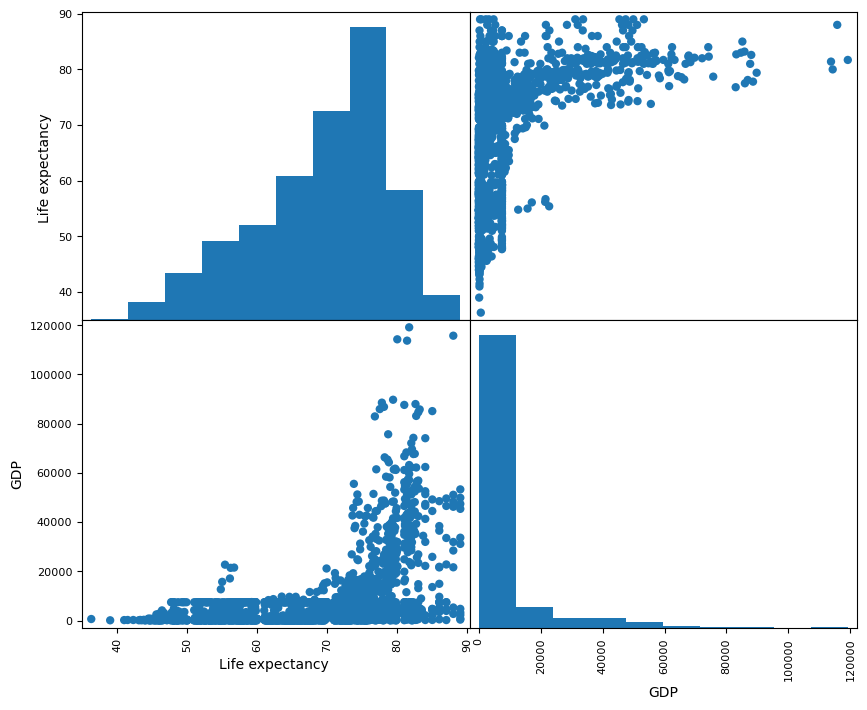

In [6]:
pd.plotting.scatter_matrix(Data[['Life expectancy ', 'GDP']],figsize=(10,8),alpha=1,marker="o")
plt.show()

**Title:** *Life Expectancy vs expenditure %*

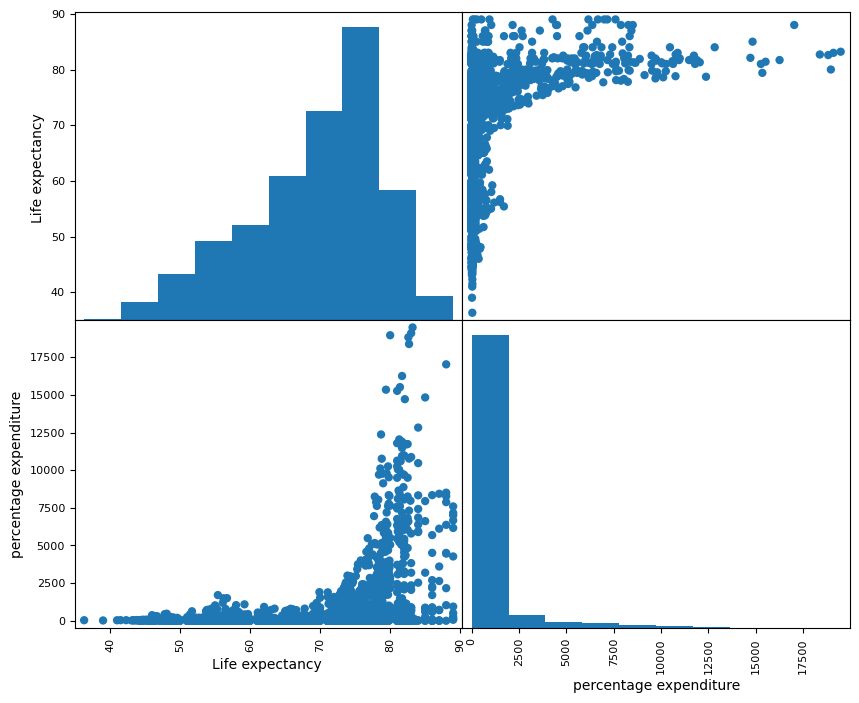

In [7]:
pd.plotting.scatter_matrix(Data[['Life expectancy ', 'percentage expenditure']],figsize=(10,8),alpha=1,marker="o")
plt.show()

**Title:** *GDP vs expenditure %*

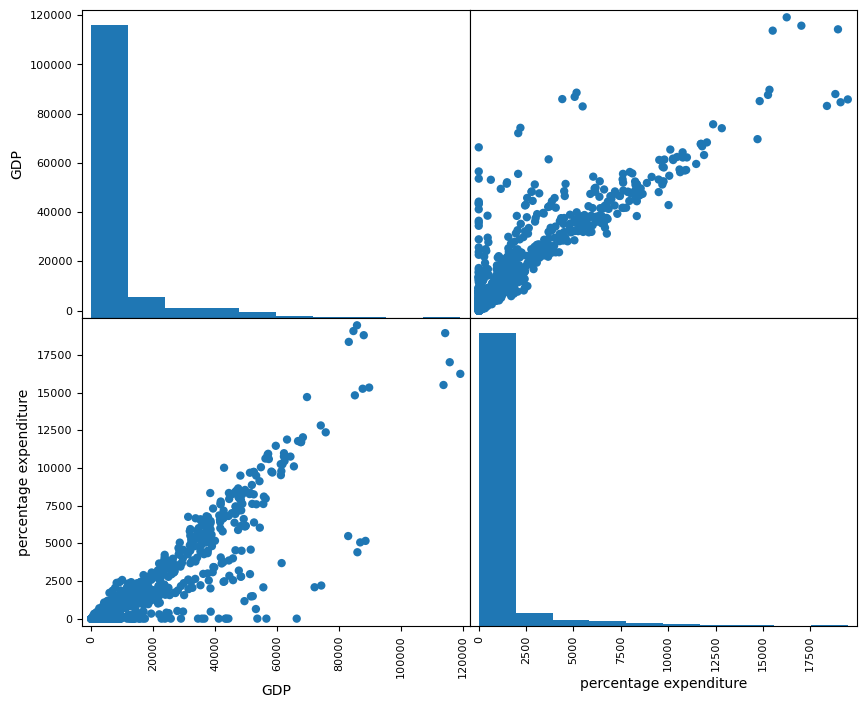

In [8]:
pd.plotting.scatter_matrix(Data[['GDP', 'percentage expenditure']],figsize=(10,8),alpha=1,marker="o")
plt.show()

**Title:** *Life Expectancy vs Schooling*

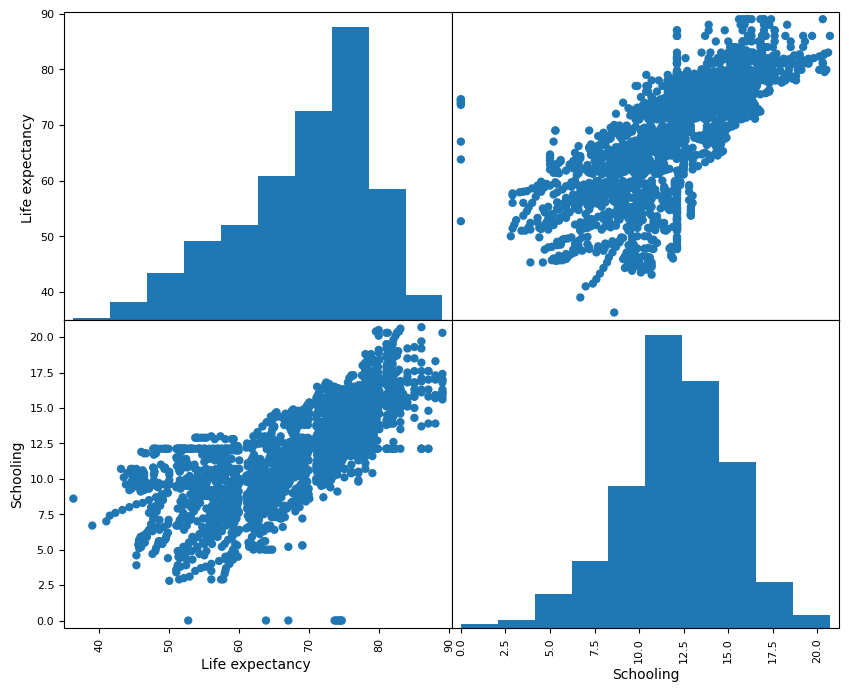

In [9]:
pd.plotting.scatter_matrix(Data[['Life expectancy ', 'Schooling']],figsize=(10,8),alpha=1,marker="o")
plt.show()

**Title:** *Life Expectancy vs Measles*

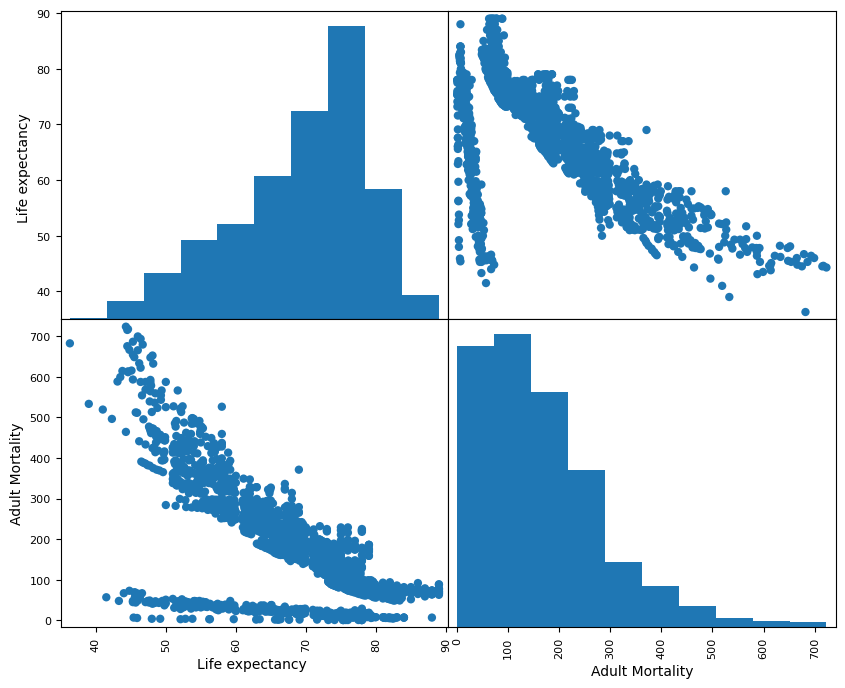

In [10]:
pd.plotting.scatter_matrix(Data[['Life expectancy ', 'Adult Mortality']],figsize=(10,8),alpha=1,marker="o")
plt.show()

**Title:** *Life Expectancy vs Population*

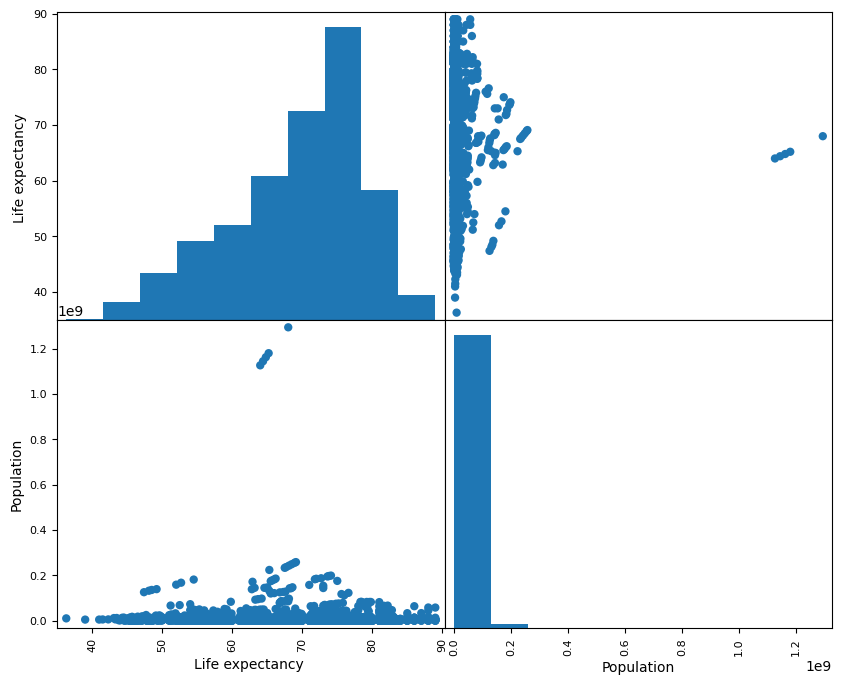

In [11]:
pd.plotting.scatter_matrix(Data[['Life expectancy ', 'Population']],figsize=(10,8),alpha=1,marker="o")
plt.show()

**Title:** *Life Expectancy vs infant deaths*

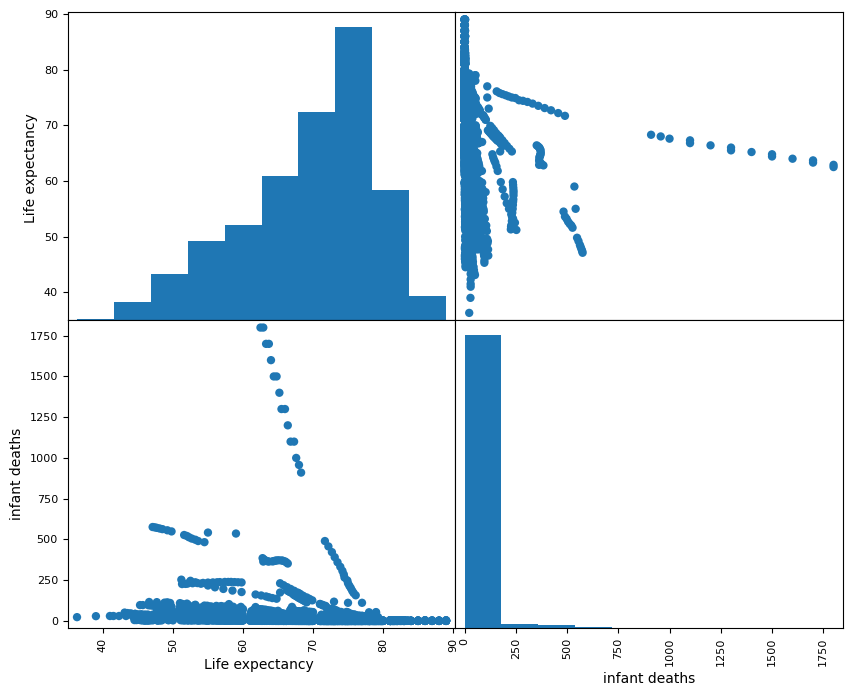

In [12]:
pd.plotting.scatter_matrix(Data[['Life expectancy ', 'infant deaths']],figsize=(10,8),alpha=1,marker="o")
plt.show()

**Title:** *Life Expectancy vs Alcohol*

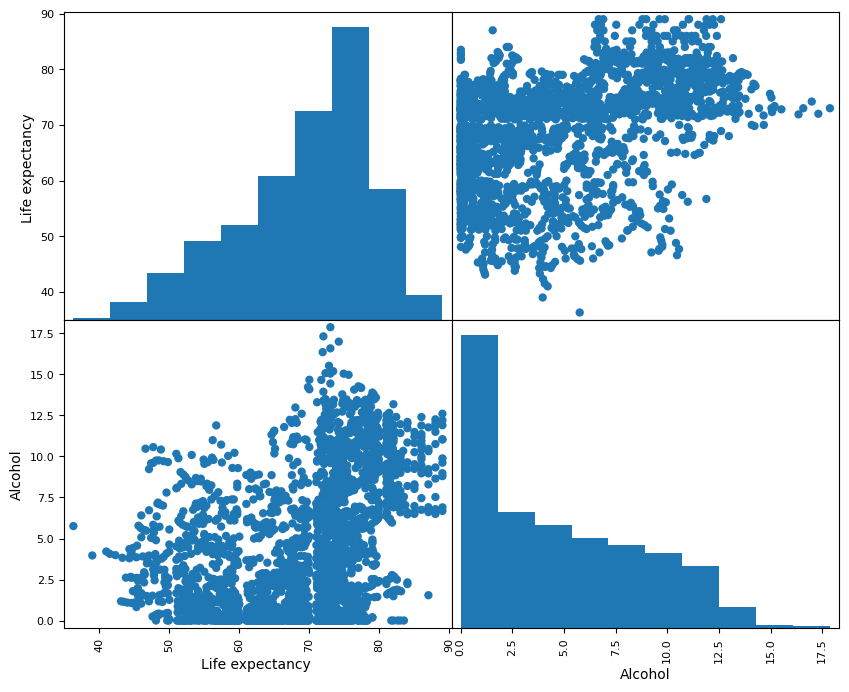

In [13]:
pd.plotting.scatter_matrix(Data[['Life expectancy ', 'Alcohol']],figsize=(10,8),alpha=1,marker="o")
plt.show()

**Title:** *Life Expectancy vs Diphtheria*

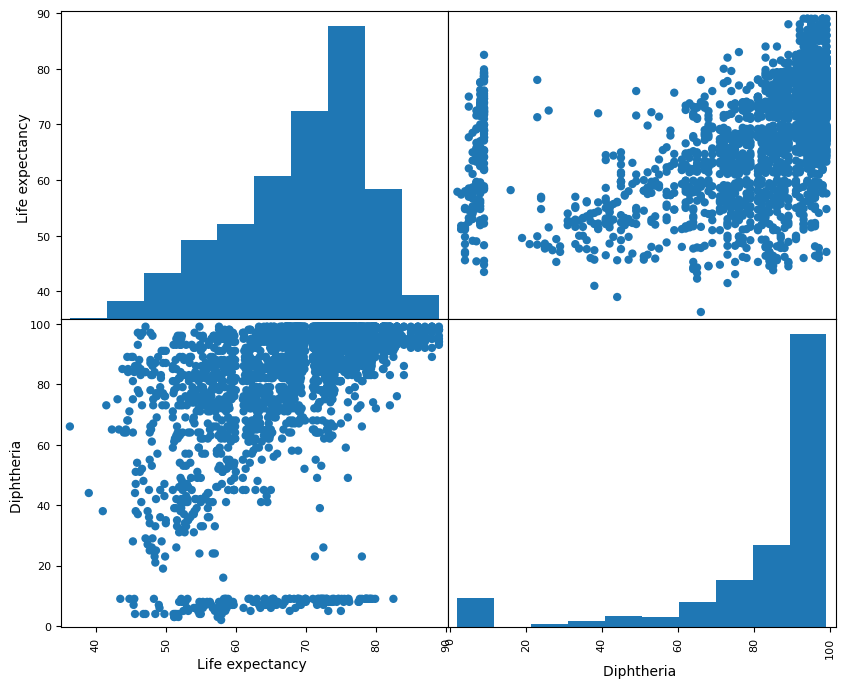

In [14]:
pd.plotting.scatter_matrix(Data[['Life expectancy ', 'Diphtheria ']],figsize=(10,8),alpha=1,marker="o")
plt.show()

**Title:** *Life Expectancy vs HIV/AIDS*

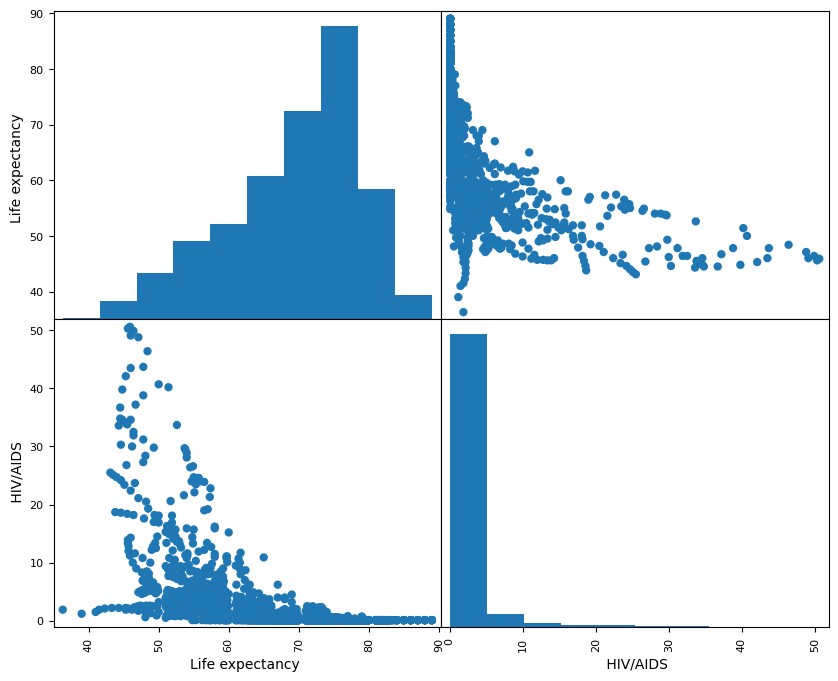

In [15]:
pd.plotting.scatter_matrix(Data[['Life expectancy ', ' HIV/AIDS']],figsize=(10,8),alpha=1,marker="o")
plt.show()

**Title:** *Life Expectancy vs BMI*

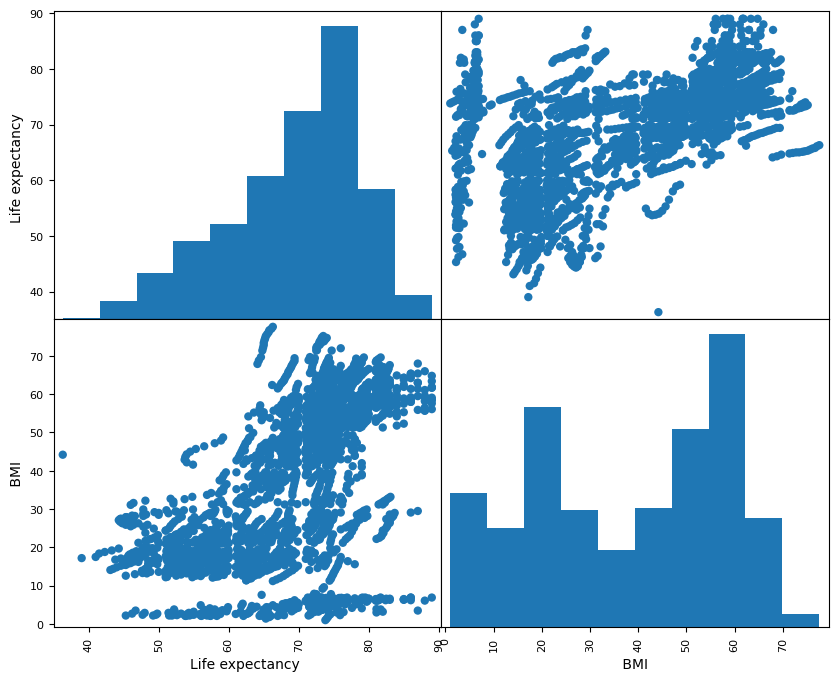

In [16]:
pd.plotting.scatter_matrix(Data[['Life expectancy ', ' BMI ']],figsize=(10,8),alpha=1,marker="o")
plt.show()

**Title:** *Life Expectancy vs Total expenditure*

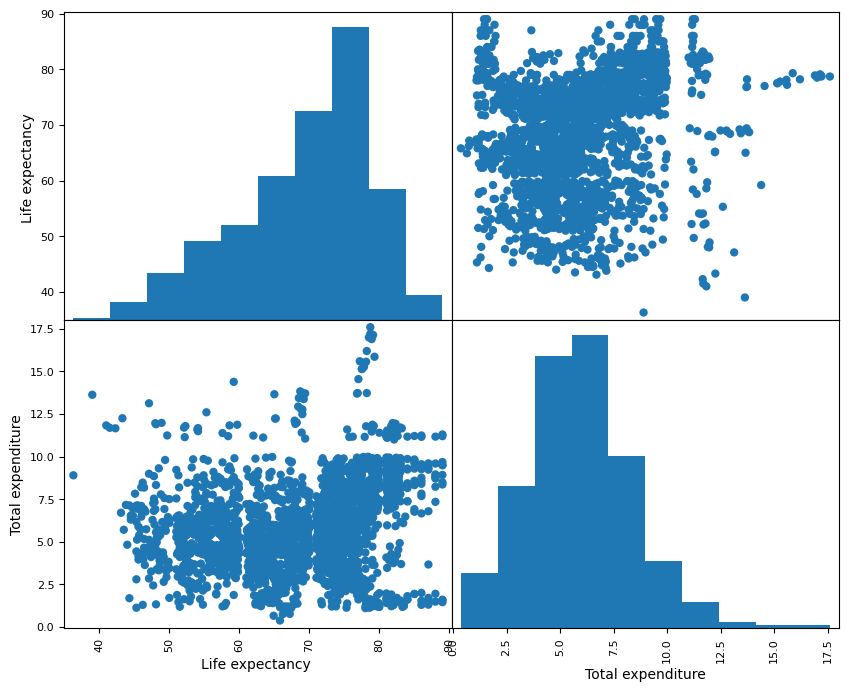

In [17]:
pd.plotting.scatter_matrix(Data[['Life expectancy ', 'Total expenditure']],figsize=(10,8),alpha=1,marker="o")
plt.show()

**Title:** *Life Expectancy vs Income composition of resources*

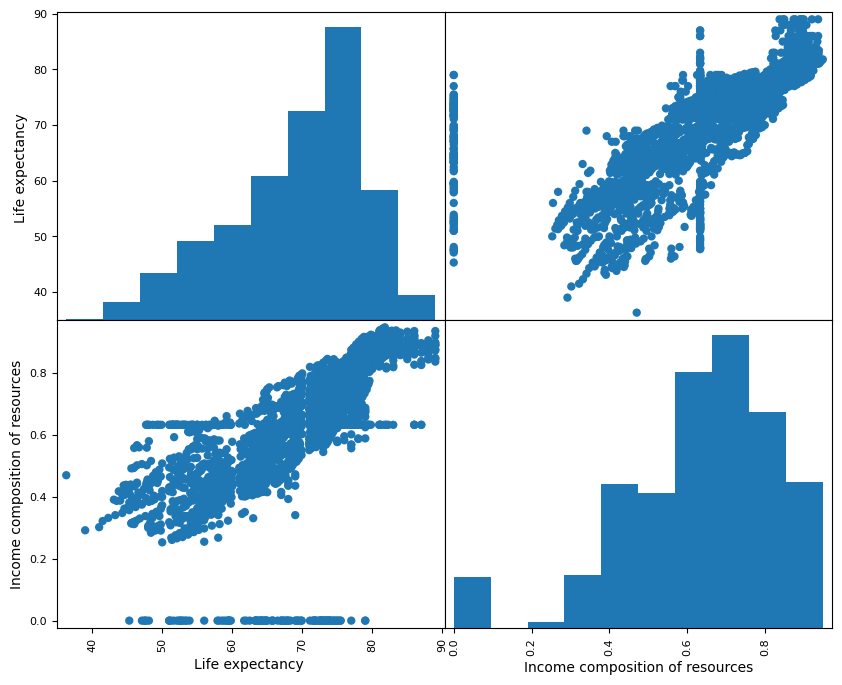

In [18]:
pd.plotting.scatter_matrix(Data[['Life expectancy ', 'Income composition of resources']],figsize=(10,8),alpha=1,marker="o")
plt.show()

# *Overall Correlationship between 'Life Expectancy' and others*

In [19]:
overall = Data.drop(["Country"], axis=1).corr()["Life expectancy "]
print(overall)
overall_vals = np.array(abs(overall.values))
overall_keys = np.array(overall.keys())
temp_sort = np.sort(overall_vals)

top_5_vals = temp_sort[-6:-1]
top_5_keys = [overall_keys[np.where(overall_vals==ind)[0][0]] for ind in temp_sort[-6:-1]]
print("\n", "Top 5 features and scores according to correlation")
print(top_5_keys[::-1])
print(top_5_vals[::-1])

Year                               0.170772
Status                             0.481549
Life expectancy                    1.000000
Adult Mortality                   -0.693189
infant deaths                     -0.197408
Alcohol                            0.407194
percentage expenditure             0.381173
Hepatitis B                        0.291595
Measles                           -0.160525
 BMI                               0.567055
under-five deaths                 -0.223172
Polio                              0.464166
Total expenditure                  0.217165
Diphtheria                         0.478194
 HIV/AIDS                         -0.560382
GDP                                0.435512
Population                        -0.020742
 thinness  1-19 years             -0.476342
 thinness 5-9 years               -0.470744
Income composition of resources    0.693158
Schooling                          0.725785
Name: Life expectancy , dtype: float64

 Top 5 features and scores according

# ***Training***